In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
#for monitoring
from time import time
#for parsing the data filename
import re

In [4]:
from multi30k_data import *
from encoder_decoder import *

In [82]:
import warnings

In [5]:
class EncodeDecodeRun :
    def __init__(self, encoder, decoder) :
        self.encoder = encoder
        self.decoder = decoder
        
        #these values will be filled by the encoders.
        self.g = None
        self.attn_values = None
        self.out = None
        
        if isinstance(encoder, EncoderSimple) :
            self.run_encoder = self.run_simple_encoder
        
        if isinstance(encoder, EncoderRNN) :
            self.run_encoder = self.run_rnn_encoder
            
        if isinstance(decoder, DecoderRNN) :
            self.run_decoder = self.run_rnn_decoder
            
        if isinstance(decoder, AttnDecoderRNN) :
            self.run_decoder = self.run_attn_decoder 
    
    def run_simple_encoder(self, x ) :
        self.out = self.encoder(x)
        self.g = self.out.view(1,1,-1)
        self.attn_values = self.encoder.embedded
        
        
    def run_rnn_encoder(self, x ) :
        self.g = self.encoder.init_hidden()
        
        self.out, self.g = self.encoder(x, self.g )
        self.g.detach_()
        self.attn_values = self.out
        
        
    def run_rnn_decoder(self, yi ) :
            #for i in range(1) :
            scores, self.g = self.decoder( yi, self.g)
            #print(scores.shape)
            #print(next_word.shape)
            return scores
    
    def run_attn_decoder(self, yi ) :
        #self.attn_values is of shape (n,d)
        #we need it as (MAX_LENGTH, d) witht he first n filled
        max_length = self.decoder.max_length
        values_to_attend = torch.zeros(max_length, self.decoder.hidden_size, device=device)
        for i in range(self.attn_values.shape[0]) :
            values_to_attend[i] = self.attn_values[i][0]
                
        scores, self.g, _ = decoder( yi, self.g, values_to_attend )
        #print(scores.shape)
        #print(next_word.shape)
        return scores

def train(encdecrun, encoder_optimizer, decoder_optimizer, criterion, train_iter ) :
    start = time()
    
    loss_db = []
    for x, y in train_iter :
        x = x.to(device)
        y = y.to(device)
        loss = 0
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        
        #h = encoder.initHidden().to(device)
        #h.detach_()
        encdecrun.run_encoder( x )
    
        #g = torch.sum( encoder_outputs, dim=0 ).view(1,1,-1)
        
        y = y.detach()
        y_len = y.shape[0] #size of sequence
        for i in range(y_len - 1) :
            scores = encdecrun.run_decoder( y[i] )
            loss += criterion(scores, y[i+1] )

        loss.backward()
        loss_db.append( float(loss) )
                
        encoder_optimizer.step()
        decoder_optimizer.step()
        
    end = time()
    print (end-start)
    return loss_db

In [6]:
train_iter = multi30k_data.val_batch(device=device)
x, y = next(train_iter)
x = x.to(device)
y = y.to(device)

/home/local/SPREADTRUM/bipin.vijayasenan/anaconda3/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)


In [8]:
hidden_size = 256
#encoder = EncoderRNN(len(multi30k_data.src_lang.vocab), hidden_size).to(device)
n_src_vocab = len(multi30k_data.src_lang.vocab)
n_trg_vocab = len(multi30k_data.trg_lang.vocab)

encoder = EncoderSimple(n_src_vocab, hidden_size).to(device)
#encoder = EncoderRNN(n_src_vocab, hidden_size).to(device)

decoder = DecoderRNN(hidden_size, n_trg_vocab).to(device)

#decoder = AttnDecoderRNN(hidden_size, len(multi30k_data.trg_lang.vocab), max_length=50  ).to(device)

print(encoder)
print(decoder)

EncoderSimple(
  (embedding): Embedding(5499, 256)
)
DecoderRNN(
  (embedding): Embedding(10839, 256)
  (gru): GRU(256, 256)
  (linear): Linear(in_features=256, out_features=10839, bias=True)
)


In [9]:
learning_rate = 0.001
#encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
encoder_optimizer = optim.Adam( filter(lambda p: p.requires_grad, encoder.parameters()) , lr=learning_rate)

decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
#criterion = nn.NLLLoss().to(device)
criterion = nn.CrossEntropyLoss().to(device)

In [10]:
encdecrun = EncodeDecodeRun(encoder,decoder)
#a = encdecrun.run_encoder( x )

In [11]:
#let us have a smaple run
a = encdecrun.run_encoder( x )

encoder_optimizer.zero_grad()
decoder_optimizer.zero_grad()

scores = encdecrun.run_decoder( y[1] )
loss = criterion(scores, y[2] )

loss.backward()

encoder_optimizer.step()
decoder_optimizer.step()

In [12]:
avg_loss = []

for _ in range(5) :
    l = train(encdecrun, encoder_optimizer, decoder_optimizer, criterion, multi30k_data.train_batch(n_data=1000) )
    m = np.mean(l)
    print("mean iteration loss", m)
    avg_loss.append( m )

15.612107515335083
mean iteration loss 69.13144373130798
15.626079082489014
mean iteration loss 45.554151527404784
16.983951807022095
mean iteration loss 30.358322249889373
18.070173501968384
mean iteration loss 17.951374409914017
17.132532596588135
mean iteration loss 10.057482401520014


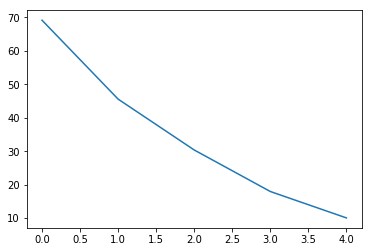

In [15]:
plt.plot(avg_loss)
#plt.plot(j)

In [88]:
#j = [ np.mean(l[i:i+100]) for i in range(200) ]

In [20]:
from torchtext.data import Field
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

#train_iter = multi30k_data.val_batch()
#for _ in range(100) : next(train_iter)
inp, out = next(train_iter)
#inp = inp.squeeze()
out = out.squeeze()
target_output   = " ".join([ multi30k_data.trg_lang.vocab.itos[i] for i in out ]) 
tout = translate( encdecrun, inp )

output_sentence = " ".join([ multi30k_data.trg_lang.vocab.itos[i] for i in tout ])
print(target_output)
#print(multi30k_data__.trg_lines[i])
print(output_sentence)
print( sentence_bleu( [target_output.split(' ')], output_sentence.split(' ') , smoothing_function=SmoothingFunction().method1) )

<sos> Three dogs playing in the snow . <eos>
<sos> Three men playing with Frisbee . <eos>
0.07751502105431508


/home/local/SPREADTRUM/bipin.vijayasenan/anaconda3/lib/python3.6/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)


In [13]:
#debug_list = []
def translate( encdecrun, x ) :
    debug_list = [] #XXX
    x = x.to(device)
    
    out = encdecrun.run_encoder( x )
    
    #first input is SOS
    next_word = x[0][0].view(1,1,1)
    predicted_target = []
    for i in range(25) :        
        scores = encdecrun.run_decoder( next_word )
        predicted_target.append( next_word.item() )
        if next_word.item() == 3 : #in_data.trg_lang.EOS_token :
            break
        #now we make the next_word from current_word
        v, next_word = scores.topk(1) #return value and index

        
    return predicted_target    
    #return " ".join([ in_data.trg_lang.itos[i] for i in predicted_target ])

In [14]:
def eval_val(encdecrun, test_iter ) :
    #test_iter = multi30k_data.train_batch()
    bleu_score = 0
    count = 0
    for inp, out in test_iter :
        target_output   = " ".join([ multi30k_data.trg_lang.vocab.itos[i] for i in out ]) 
        tout = translate( encdecrun, inp )
        output_sentence = " ".join([ multi30k_data.trg_lang.vocab.itos[i] for i in tout ])
        bleu_score += sentence_bleu( [target_output.split(' ')], output_sentence.split(' '), 
                                    smoothing_function=SmoothingFunction().method1)
        count += 1
    return bleu_score/float(count)

In [95]:
eval_val(encdecrun, multi30k_data.val_batch())
#Training on trianing set (first 1000), eval on val set
# RNN Encoder Decoder
#5 iter : 0.04284566223317566

#Training on trianing set (first 1000), eval on val set
# SimpleEncoder RNNDecoder
#5 iter : 0.08086874335565286

#0 iter : 0.007594141420805346 ( No training; random init )
#1 iter (2K) : 0.08813359634828569
#1 iter (20K): 0.12253828240795721
#20 iter (20K) : 

0.08294689595420113

In [94]:
eval_val(encdecrun, multi30k_data.train_batch(n_data=1000))

0.8642076513814061

In [86]:
#EncoderRNN, AttnDecoderRNN
#torch.save(encoder.state_dict(), 'encoder.pt')
#torch.save(decoder.state_dict(), 'decoder.pt')